- *Autor: Alessandro Perales*
- *Perfil de GitHub: https://github.com/alessandroperales74*

# Modelo de Clustering con K-Means

En esta ocasión, en mi trabajo se me ha pedido que identifique los proveedores críticos y no críticos en función al volumen de facturación. Esto para poder segmentar y tomar diferentes planes de acción para cada uno de estos grupos de proveedores.

Para esto, estoy utilizando un **modelo de clustering** aplicando el método de **k-means** para poder agrupar a estos proveedores por estos dos criterios utilizando herramientas de Machine Learning. 

A continuación les muestro el paso a paso de este sencillo modelo para que lo puedan replicar y adaptar a sus necesidades.

## 1. Importación de Librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

## 2. Lectura del Dataset

In [2]:
# Importamos el DataFrame
df = pd.read_csv('proveedores.csv')

In [3]:
# Muestra de 5 datos aleatorios del dataframe
df.sample(5)

,cod_proveedor,total_facturas,total_importe
5303,1000034856,9,60869.63
3627,1000022289,3,3218.92
983,1000001716,2,4337.00
3057,1000011448,61,152000.00
3559,1000022087,402,511919.71


In [4]:
# Vamos a generar una copia del cluster para hacer el pre-procesamiento
df_cluster = df.copy()

## 3. Normalización de los Datos usando Min Max Scaler

In [5]:
# Para el proceso de Clustering necesitamos normalizar los datos para facilitar su análisis
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_cluster[['total_importe', 'total_facturas']])

# Crear un MinMaxScaler para cada columna por separado
scaler_importe = MinMaxScaler()
scaler_facturas = MinMaxScaler()

# Ajustar y transformar los datos de 'total_importe' y 'total_facturas' por separado
df_cluster['total_importe_scaled'] = scaler_importe.fit_transform(df_cluster[['total_importe']])
df_cluster['total_facturas_scaled'] = scaler_facturas.fit_transform(df_cluster[['total_facturas']])

# Ahora puedes ver los valores escalados entre 0 y 1
print(df_cluster[['total_importe_scaled', 'total_facturas_scaled']].describe())

       total_importe_scaled  total_facturas_scaled
count           5756.000000            5756.000000
mean               0.003483               0.004326
std                0.023310               0.023035
min                0.000000               0.000000
25%                0.000021               0.000033
50%                0.000116               0.000293
75%                0.000784               0.001465
max                1.000000               1.000000


Aquí podemos ver que nuestra normalizazión de datos ha funcionado correctamente ya que ada valor está entre 0 a 1.

## 4. Entrenamos el modelo usando K-Means

En este caso, solo necesito saber si el proveedor es Crítico o No Crítico en función a su volumen de facturación y a al importe. Por ejemplo, puede ser que no facturen demasiado en cuanto a volumen, pero sean importen muy considerables, o proveedores cuyo volumen de facturación sea considerable.

In [6]:
# Creamos el modelo K-Means
kmeans = KMeans(n_clusters=2, random_state=42)  # Puedes ajustar el número de clusters
kmeans.fit(X_scaled)

C:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


KMeans(n_clusters=2, random_state=42)

In [7]:
# Se agrega la columna de Cluster al DataFrame Original
df['cluster'] = kmeans.labels_

## 5. Gráfico de Dispersión

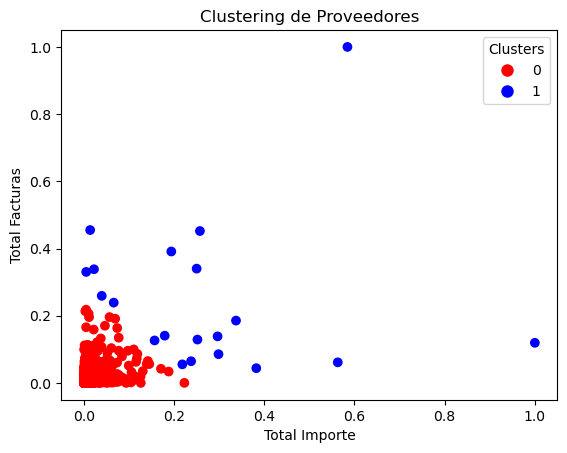

In [8]:
# Se le asigna un color a cada cluster. Puedes añadir alguno de los 
colors = ['red', 'blue']

# Grafico de Dispersión
plt.scatter(df_cluster['total_importe_scaled'], df_cluster['total_facturas_scaled'], c=[colors[label] for label in kmeans.labels_])

plt.xlabel('Total Importe')
plt.ylabel('Total Facturas')
plt.title('Clustering de Proveedores')

# Crear una lista de colores únicos para la leyenda
unique_labels = np.unique(kmeans.labels_)

# Crear la leyenda con colores correctos
legend_handles = [plt.Line2D([0], [0], 
                             marker='o', 
                             color='w', 
                             markerfacecolor=colors[label], 
                             markersize=10) for label in unique_labels]

# Agregar Leyenda
plt.legend(legend_handles, unique_labels, title='Clusters')
plt.show()

En esta gráfica podemos ver que se han seleccionado dos clusters:

<div style="color:blue">
1. Los <b>azules</b> son proveedores que tienen mucho volumen de facturación o tienen mucho importe facturado, por lo que asumimos que estos proveedores serán nuestros **proveedores críticos**
</div>

<div style="color:red">
2. Los <b>rojos</b> representan proveedores con menor volumen de facturación y poco volumen en importe, por lo que los vamos a considerar como **proveedores no críticos**
</div>

## 6. Evaluando el Modelo

In [9]:
# Calcular métricas
silhouette = silhouette_score(X_scaled, kmeans.labels_)
inertia = kmeans.inertia_
db = davies_bouldin_score(X_scaled, kmeans.labels_)
ch = calinski_harabasz_score(X_scaled, kmeans.labels_)

In [10]:
list_results = {
    'Evaluation':['Silhouette Score','Inertia','Davies-Bouldin','Calinski-Harabasz'],
    'Score': [silhouette,inertia,db,ch]    
}

In [11]:
results = pd.DataFrame(list_results)
results

,Evaluation,Score
0,Silhouette Score,0.974427
1,Inertia,3.591366
2,Davies-Bouldin,0.723438
3,Calinski-Harabasz,4148.852548


**¿Qué podemos interpretar de cada modelo, según sus métricas?**

De antemanos debemos aclarar que, en un modelo de clustering tenemos que buscar dos cosas:

- **La cohesión de los puntos dentro de los clusters**. Mientras más cercanos estén los puntos dentro del cluster, mejor. 
- **La mayor separación posible entre los clusters**. Mientras mayor separación haya entre un cluster y los demás, mejor.


1. *Silhouette Score*: Por definición, esta métrica de evaluación va de un rango de 1 a -1, siendo 1 lo más optimo (clusters bien cohesionados y separados de otros clusters. Un valor igual cercano a -1 indica que los clusters están superpuestos, por lo que el modelo no ha podido diferencias los datos entre los clusters. Teniendo eso en cuenta, un valor de **0.974427** es bastante óptimo, lo que indica que mis clusters están muy bien definidos.
  
2. *Inertia*: Esta métrica está basada en los centroides, que son los puntos centrales de los clusters. Técnicamente hablando, es la suma de las distancias cuadrados entre los puntos y el centroide más cercano. No es tan interpretable como el Silhouette Score, sino que hay que compararlo con otras métricas y con el número de clusters. Lo ideal es que el valor sea lo más bajo posible y, con un valor de **3.591366** lo que indica que los puntos están bien compactados.

3. *Davies-Bouldin Index*: Aquí se busca evaluar la dispersión de puntos dentro de los clusters así como la separación interclusters. Un valor bajo, y lo más cercano a cero indica alta cohesión, lo que es óptimo. En este caso, tenemos **0.723438**, lo que habla bastante bien de nuestro modelo.

4. *Calinski-Harabasz Index*: En esta métrica, a diferencia de las otras, se busca que el número sea lo más alto posible. Un número más alto indica mayor densidad de los clusters y una mejor estructuración. Dado que el valor de **4148.85** es muy alto, se concluye que los clusters están bien definidos, son compactos y están separados de manera adecuada.

In [12]:
# Vemos cómo se han agrupado los clusters en el Dataframe original
df.groupby('cluster').agg({'total_facturas':'sum','total_importe':'mean'}).reset_index().round()

,cluster,total_facturas,total_importe
0,0,618229,1054654.0
1,1,152193,110138709.0


Como lo pudimos apreciar en el gráfico de dispersión, en el cluster 0 (no críticos) vemos que tienen más volumen de facturación, pero el importe es considerablemente más pequeño que en cluster 1 que tiene menos volumen (críticos), por lo que nuestro clustering hace bastante sentido y conversa bastante bien con nuestras métricas.

In [13]:
# Aquí exporto el dataframe original para poder revisar con mayor detalle los clusters
df.to_csv('proveedores clustering.csv',index=False)